### Ria Ann De la Cruz | BS in Computer Science IV

In [122]:
##### Standard Libraries #####
import numpy as np
import pandas as pd
from numpy import log, dot, e
import os
import re
import email
import glob
import csv
import matplotlib.pyplot as plt

%matplotlib inline

##### For Preprocessing #####
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

##### For Building the Model #####
from sklearn.pipeline import make_pipeline

##### For Validation of the Model #####
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

### Loading and Pre - processing Data 

In [132]:
#Getting each word in the text by splitting it
def convert(lst):
    return ''.join(lst).split()  

In [133]:
def preprocess_text(cl_text):
    cl_text = str(cl_text)
    cl_text = re.sub(r'[^\w\s]', " ", cl_text) #remove puntuation
    cl_text = re.sub(r"\b[0-9]+\b\s*", " ", cl_text) #Remove numbers
    cl_text = cl_text.lower()  # Lowercase text
    cl_text = compare(cl_text) #removing stop words
    return cl_text

In [134]:
#calling the stop words text file
def compare(tokenize):
    with open('stop_words.txt', "r") as f:
        stop_words = f.read()
        label = convert(stop_words)
        tokens = tokenize.split()
        clean_tokens = [t for t in tokens if not t in label]
        clean_text = " ".join(clean_tokens)
    return clean_text

### Access email files

In [6]:

# Set the directory containing the email files
email_dir = 'data'
t_list = []
i = 0

# Traverse the directory and subdirectories
for root, dirs, files in os.walk(email_dir):
    for file in files:
        # Open the email file
        with open(os.path.join(root, file), 'rb') as fp:
            # Parse the email message
            msg = email.message_from_binary_file(fp)
            if msg.is_multipart():
                for payload in msg.get_payload():
                    # if payload.is_multipart(): ...
                    body = payload.get_payload()
            else:
                body = msg.get_payload()
            
            # clean text
            body_str = preprocess_text(body)
            if i != 0:
                t_list.append(body_str)
            else:
                i+=1


### Creating a dataframe with labels

In [7]:
labels = []
df = pd.DataFrame()
with open('labels.txt', 'r') as f:
    # create a CSV reader
    reader = csv.reader(f, delimiter=' ')
    
    # iterate over the rows in the file
    for row in reader:
        # extract the label and path from the row
        label = row[0]
        path = row[1]
        labels.append(label)

df["EmailMessage"] = t_list
df["Category"] = labels

df.head()

,EmailMessage,Category
0,mailing list queried weeks ago running set arc...,ham
1,luxury watches buy rolex rolex cartier bvlgari...,spam
2,academic qualifications prestigious acc redite...,spam
3,greetings verify subscription plan9 fans list ...,ham
4,html head meta http equiv content language con...,spam


### Getting the training and testing set

In [8]:
#x = (df-np.mean(df))/np.std(df)
#y = df
train, test = train_test_split(df, train_size=21300, random_state=42)
total_train = train.shape
print("train size:", total_train)
print("test size:", test.shape)

train size: (21300, 2)
test size: (16522, 2)


In [135]:
train.head() #checking what thw train set looks like

,EmailMessage,Category
4245,referring course wonderful blue pill erection ...,spam
27825,doctype html public w3c dtd html transitional ...,spam
22305,doctype html public w3c dtd html transitional ...,spam
21622,html head meta http equiv content language con...,spam
1224,html head meta http equiv content language con...,spam


#### Creating spam_train and ham_train sets

In [136]:
groups = train.groupby('Category')
spam_train = groups.get_group('spam') #group based on spam category
ham_train = groups.get_group('ham') #group based on ham category
total_spam = spam_train.shape
total_ham = ham_train.shape

### Creating the feature matrices

In [137]:
#Creating function for getting the feature matrices
def words_frequency(text):
    #creating dictionary for the tokens
    token_counts = {}
    
    #counting the number of times each token found in email
    for index, value in text['EmailMessage'].iteritems():
        for token in value.split():
            if token not in token_counts:
                token_counts[token] = 1
            else:
                token_counts[token] += 1
                
    #filtered_dict = {word: count for word, count in token_counts.items() if count == 50}
    # sort the dictionary by value and keep the top 10000 tokens
    top_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:10000]
    
    
    # create an empty list to store the feature vectors
    train_vectors = []

    # loop through the spam training data and create a feature vector for each document
    for index, value in text['EmailMessage'].iteritems():
        # create an empty feature vector
        vector = [0] * 10000
  
        # loop through the tokens in the document and update the feature vector
        for token in value.split():
            if token in top_tokens:
                vector[top_tokens.index(token)] += 1
  
        # add the feature vector to the list of vectors
        train_vectors.append(vector)
        

    #return list
    return train_vectors
    

#### Feature matrix for spam train set

In [138]:
spam_train_matrix = np.array(words_frequency(spam_train))
spam_train_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### Feature matrix for ham train set

In [139]:
ham_train_matrix = np.array(words_frequency(ham_train))
ham_train_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Computing the Priors

In [107]:
prior_ham = total_ham[0]/total_train[0]
prior_spam = total_spam[0]/total_train[0]
print("Prior probabilities for ham:", prior_ham)

print("Prior probabilities for spam:", prior_spam)

Prior probabilities for ham: 0.3459154929577465
Prior probabilities for spam: 0.6540845070422535


### Computing the Likelihood of each word

In [140]:
#Creating a dataframe for spam features
spam_df = pd.DataFrame(spam_train_matrix)
spam_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
#Creating dataframe for ham features
ham_df = pd.DataFrame(ham_train_matrix)
ham_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# Smoothing parameter
k = 1

# Vocabulary size (number of different words in the dictionary)
vocab_size = 10000

# Compute the likelihood of each word given that an email is spam
spam_likelihoods = (spam_df.sum(axis=0) + k) / ((spam_df.sum().sum()) + (k * vocab_size))

# Compute the likelihood of each word given that an email is ham
ham_likelihoods = (ham_df.sum(axis=0) + k) / ((ham_df.sum().sum()) + (k * vocab_size))

print("Likelihoods of Spam words:\n", spam_likelihoods)
print("Likelihoods of Ham words:\n", ham_likelihoods)

Likelihoods of Spam words:
 0       0.0001
1       0.0001
2       0.0001
3       0.0001
4       0.0001
         ...  
9995    0.0001
9996    0.0001
9997    0.0001
9998    0.0001
9999    0.0001
Length: 10000, dtype: float64
Likelihoods of Ham words:
 0       0.0001
1       0.0001
2       0.0001
3       0.0001
4       0.0001
         ...  
9995    0.0001
9996    0.0001
9997    0.0001
9998    0.0001
9999    0.0001
Length: 10000, dtype: float64


In [142]:
#Creating the word dictionary
def word_dic(text,likelihood):
    token_counts = {}
    for index, value in text['EmailMessage'].iteritems():
        for token in value.split():
            if token not in token_counts:
                token_counts[token] = 1
            else:
                token_counts[token] += 1
    
    #filtered_dict = {word: count for word, count in token_counts.items() if count == 50}
    # sort the dictionary by value and keep the top 10000 tokens
    top_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:1000]
    
    top_words = list(zip(*top_tokens))[0]
    
    l_df = pd.DataFrame({top_words[i]: likelihood[i] for i in range(len(top_words))}, index=[0])
    
    return l_df

In [143]:
#word dictionary dataframe for spam set
l_spam = word_dic(spam_train,spam_likelihoods)
l_spam.head()

,div,3d,font,br,td,span,strong,http,ee,e5,...,3d18,early,rcg,tech,9e,completion,hard,f8e61a,r5a,position
0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001


In [144]:
#word dictionary dataframe for ham set
l_ham = word_dic(ham_train,ham_likelihoods)
l_ham.head()

,nbsp,font,arizona,dmdx,3d,br,psych,psy1,http,div,...,limit,external,lugnet,theory,third,equipment,sense,arbitrary,starting,government
0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001


### Classifying the emails

In [145]:
import math

# Define the category or classes
classes = ["spam", "ham"]

# assign the prior probabilities for each categories
priors = {"spam": prior_spam, "ham": prior_ham}

# Load the spam and ham likelihoods from the dataframes
s_likelihoods = l_spam.to_dict()
h_likelihoods = l_ham.to_dict()
likelihoods = {
    "spam": s_likelihoods,
    "ham": h_likelihoods
}

# Define a function to classify an email
def classify(email):
    # Initialize the log posterior probabilities for each class
    posteriors = {cat: math.log(priors[cat]) for cat in classes}
    
    # Calculate the log posterior probabilities for each class
    for cat in classes:
        #for index, value in email['EmailMessage'].iteritems():
        for word in email.split():
            if word in likelihoods[cat]:
                l = likelihoods[cat][word]
                # Make sure the value is a real number
                if isinstance(l, (int, float)):
                    posteriors[cat] += math.log(l)
    
    # Normalize the log posterior probabilities
    max_posterior = max(posteriors.values())
    posterior = {cat: p-max_posterior for cat, p in posteriors.items()}
    posterior = {cat: math.exp(p) for cat, p in posteriors.items()}
    total = sum(posterior.values())
    posterior = {cat: p/total for cat, p in posteriors.items()}
    
    # Return the class with the highest posterior probability
    return max(posterior, key=posterior.get)


In [146]:
#getting the status or prediction of each email
def status(emails):
    mail_prediction = []
    for index, value in emails['EmailMessage'].iteritems():
        prediction = classify(value) #use the classification function to determine whether it is spam or ham
        mail_prediction.append(prediction) #attach it as a predicted value
    return mail_prediction

In [147]:
#checker function to be used by different frames
def checking(frame):
    prediction = status(frame)
    new_frame = frame.assign(Prediction=prediction) #attach to the dataframe
    return new_frame

### Testing the Classifier

In [148]:
#Training set
train_update = checking(train) 
train_update.head()

,EmailMessage,Category,Prediction
4245,referring course wonderful blue pill erection ...,spam,spam
27825,doctype html public w3c dtd html transitional ...,spam,spam
22305,doctype html public w3c dtd html transitional ...,spam,spam
21622,html head meta http equiv content language con...,spam,spam
1224,html head meta http equiv content language con...,spam,spam


In [149]:
#Testing set
test_update = checking(test)
test_update.head()

,EmailMessage,Category,Prediction
36107,feel comfortable purify reading tutorials puri...,ham,spam
18363,help ir output problem hb modulating signal 41...,ham,spam
17277,hello trouble figuring wire precision navigati...,ham,spam
1640,twvtymvycywncg0kumvzb3j0ien8dwjzihxudgvybmf0aw...,spam,spam
24679,html head meta http equiv content language con...,spam,spam


### Performance Evaluation

In [150]:
#Define a function for its true positive, true negative, false positive and false negative value
def performance(test_set):
    # Initialize the counts
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i_true,true  in test_set['Category'].iteritems():
        for i_pred, predicted in test_set['Prediction'].iteritems():
            if true == "spam" and predicted == "spam":
                TP += 1
            elif true == "spam" and predicted == "ham":
                FN += 1
            elif true == "ham" and predicted == "spam":
                FP += 1
            elif true == "ham" and predicted == "ham":
                TN += 1
    return TP, TN, FP, FN

#### Getting the True positive, True negative, False positive and False negative

In [120]:
evaluate = performance(test_update)
tp = evaluate[0]
tn = evaluate[1]
fp = evaluate[2]
fn = evaluate[3]
print("True positive:", tp)
print("True Negatuve:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

True positive: 181411560
True Negatuve: 0
False Positive: 91564924
False Negative: 0


#### Getting the Accuracy, Recall and Precision

In [151]:
#Accuracy
accuracy = ((tn+tp)/(tn+tp+fp+fn))*100
print("Accuracy:", accuracy)

#Recall
recall = (tp /(tp+fn))*100
print("Recall:", recall)

#Precision
precision = (tp / (tp+fp))*100
print("Precision:", precision)

Accuracy: 66.45684541823023
Recall: 100.0
Precision: 66.45684541823023


### Answers to guide questions

In [32]:
def change(elements):
    for i in range(len(elements)):
        if elements[i] == "ham":
            elements[i] = 0
        else:
            elements[i] = 1
    return elements      

In [125]:
y_true = change(test_update['Category'].tolist())
y_pred = change(test_update['Prediction'].tolist())

# Calculate the accuracy
accu = accuracy_score(y_true, y_pred)
print(accu)
# Calculate the precision
pre = precision_score(y_true, y_pred)
print(pre)
# Calculate the recall
rec = recall_score(y_true, y_pred)
print(rec)
#y_true


0.6645684541823024
0.6645684541823024
1.0


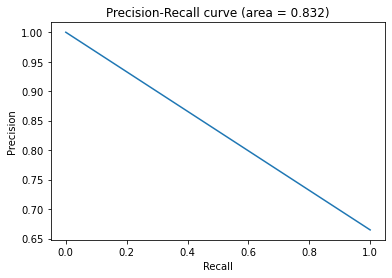

In [130]:
from sklearn.metrics import auc, precision_recall_curve

# Generate some random data
y_score = [tp,tn,fp,fn]

# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Calculate the area under the curve
area = auc(recall, precision)

# Plot the curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (area = {:.3f})'.format(area))
plt.show()
